## Vessel: Lesson

Imports and visualization functions

In [1]:
from IPython.display import display, HTML,clear_output

from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from copy import deepcopy

import sys
sys.path.append('../../')
from chemistrylab.chem_algorithms import vessel,material


def display_side_by_side(**tables):
    """Display tables side by side to save vertical space
    Input:
        tables: name , pandas.DataFrame pairs
    """
    output = ""
    for caption, df in tables.items():
        caption = " ".join(caption.split("_"))
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += "\xa0\xa0\xa0"
    display(HTML(output))
    
    

def plot_layers(vessels,cmap='cubehelix'):
    """Function to display the layer observations"""
    v0 = vessels[0]
    fig,axs = plt.subplots(1,len(vessels))
    if len(vessels) ==1:axs=[axs]

    cvals = (np.array([v0.material_dict[mat]._color for mat in v0.solvents]+[0.65])+0.2)%1
    im = axs[-1].imshow([cvals],cmap=cmap,vmin=0,vmax=1)
    colors = [ im.cmap(im.norm(value)) for value in cvals]
    patches = [ mpatches.Patch(color=colors[i],label= name) for i,name in enumerate(list(v0.solvents)+["air"]) ] 
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )

    for i,ax in enumerate(axs):
        ax.imshow((np.stack([vessels[i]._layers]*40).T[::-1] +0.2)%1,vmin=0,vmax=1,cmap=cmap)
        ax.set_xticks([])
        ax.set_yticks([])
        #ax.legend()
        fig.tight_layout()
    plt.show()



### Overview:

In this lesson, we will be going through a class that is vital to the operation of all of our benches, the vessel class.
The source code for this can be found here: `chemistrylab/chem_algorithms/vessel.py`. The vessel class as it is named is
meant to simulate the use of any given you might find in a chemistry lad, such as a beaker or an extraction vessel.
Here we will be going through the important concepts, functions and attributes that make up the vessel class so that you
can easily use it when designing your own reactions.

If you want a more detailed look into each function of the vessel I suggest you go to our [documentation]() on the data
structure. 

The Vessel class serves as any container you might find in a lab, a beaker, a dripper, etc. The vessel class simulates and allows for any action that you might want to perform within a lab, such as draining contents, storing gasses from a reaction, performing reactions, mix, pour, etc. This is performed using an event queue, which we will look at later in this lesson. First an overview of some of the important variables that make up the vessel class:

Important Variables |Structure | Description
---|---|---
material_dict|{str(material): material, ...}|a dictionary holding all the material inside this vessel
solvents| [str(material), ...] | A list of solute names
solute_dict|{str(solute): array[len(solvents)] , ...}| dictionary that represents the solution



## An example vessel:


In [2]:
v=vessel.Vessel("A")
H2O = material.H2O(mol=1)
Na,Cl = material.NaCl().dissolve().keys()
Na.mol=Cl.mol=1
C6H14 = material.C6H14(mol=1.0)
ether=material.DiEthylEther(mol=0.5)
dodecane = material.Dodecane(mol=2)

v.material_dict={str(Na):Na,str(Cl):Cl,str(C6H14):C6H14,str(H2O):H2O,str(dodecane):dodecane}

v.validate_solvents()
v.validate_solutes()

display_side_by_side(Materials = v.get_material_dataframe(), Solutes = v.get_solute_dataframe())

To briefly describe above, the material_dict describes the materials contained within a vessel and the quantity of that material. The material dict is a dictionary of (material.name, material instance) pairs. As for the solute dict, it represents how much each solute is dissolved in each solvent. Above we can see that each solute is dissolved in 50% water and 50% oil.


Next we will look at some of the important functions that we will need to use with the vessel class:

Important functions | Description
---|---
push_event_to_queue()|used to pass event into the vessel
validate_solvents()| Call when manually updating the material dict in order to update the solvent list
validate_solutes()| Call when manually updating the material dict in order to update the solute_dict

From the list above, the most important function is push_event_to_que(). The rest of the functions are generally handeled in the backend.

#### Event Functions
Function Name|Description
---|---
'pour by volume'|Pour from self vessel to target vessel by certain volume
'pour by percent'| Pour a fraction of all contents in one vessel into another
'drain by pixel|Drain from self vessel to target vessel by certain pixel
'mix'| Shake the vessel or let it settle
'update_layer'|Update self vessel's layer representation
'change heat'| Add or remove heat from the vessel,
'heat contact'| Connect the vessel to a reservoir for heat transfer,


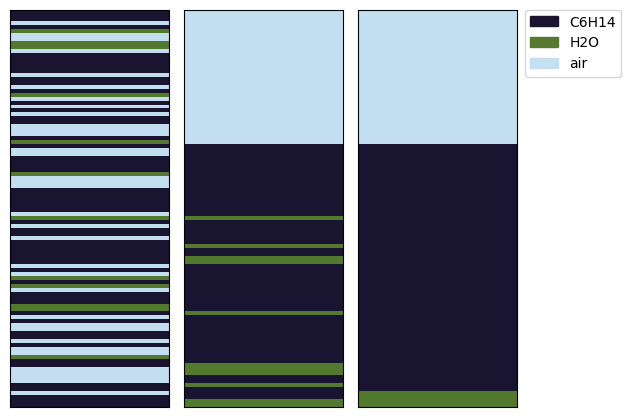

,C6H14,H2O
Na,0.802160,0.197840
Cl,0.802160,0.197840
dodecane,1.604319,0.395681
,C6H14,H2O
Na,0.756367,0.243633
Cl,0.756367,0.243633
dodecane,1.649199,0.350801
,C6H14,H2O
Na,0.674302,0.325698
Cl,0.674302,0.325698


In [3]:
v2,v3 = deepcopy(v),deepcopy(v)
v.push_event_to_queue([vessel.Event('mix',[-1],None)],0)
v2.push_event_to_queue([vessel.Event('mix',[0.02],None)])
v3.push_event_to_queue([vessel.Event('mix',[0.5],None)])


plot_layers([v,v2,v3])

display_side_by_side(
    Mixed            = v.get_solute_dataframe(), 
    Partially_settled= v2.get_solute_dataframe(), 
    Fully_Settled    = v3.get_solute_dataframe())

To visualize what we are doing above, we have several graphs:

Here we have a graph of the seperation between the oil and the water when we initially add them to our vessel

![added oil and water](../../docs/tutorial_figures/vessel/vessel_1.png)

Here we have the solution after we drain some of it (notice that the top of the vessel is now air):

![drained oil and water](../../docs/tutorial_figures/vessel/vessel_2.png)
#### The Workflow
  
  1. Agent choose action from the action space of an environment.
  2. The environment does the calculation and update and generate events.
  3. At the end of each action, if the action affect a vessel, use push_event_to_queue() to push the event into the vessel, if no event generated, call the function with events=None.
  4. With push_event_to_queue() called, events are pushed into the vessel.
  5. _update_materials is automatically called and perform events in the events_queue.
  6. Each event has a corresponding event function, it first update properties of the vessel, then loop over the materials inside the vessel by calling the corresponding event functions of each material.
  7. The materials' event function will return feedback by calling the push_event_to_queue(), which contains feedback and unfinished event 
  8. The returned feedback is added to the _feedback_queue
  9. The the _merge_event_queue() is called on _feedback_queue, which merge the events in the feedback_queue to generate a merged_queue and add default event into it, then empty the _feedback_queue
  10. Then the merged_queue will be executed and new feedback are collected and added to _feedback_queue, which will be executed with the next action. 

